# Quantitative segmentation quality estimation

Often we  face the problem, that we have an annnotated image of some data and a segmented version of the same image, which was obtained with some segmentation pipeline (StarDist, EPySeg, PlantSeg, etc). This notebook provides a method to compare the overlap of both ground truth image and achieved segmentation.

In [73]:
import os
import biapol_utilities as biau
from skimage import io, measure, segmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

##  Input data
First, let's generate some example data!

In [ ]:
blobs = biau.data.blobs()

Let's segment  this and take it as a ground truth image:

<IPython.core.display.Javascript object>


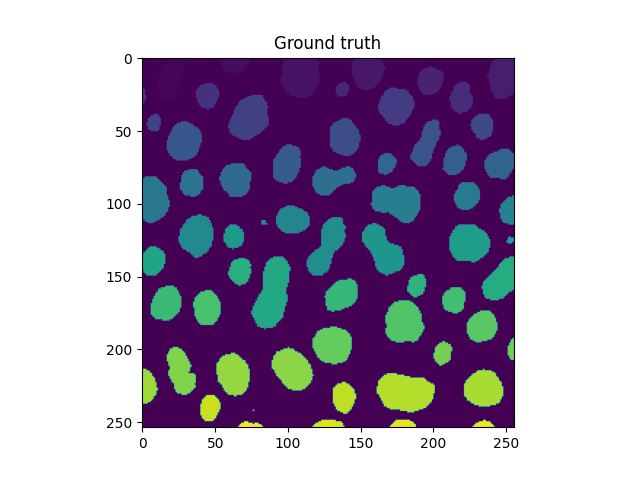

Text(0.5, 1.0, 'Ground truth')

In [10]:
threshold = 128
imageA = (blobs > threshold).astype(np.uint8)
ground_truth = measure.label(imageA)

plt.imshow(ground_truth)
plt.title('Ground truth')

Next, we shuffle the labels and expand them a bit:

In [50]:
# First, shuffle randomly
label_shuffle = np.arange(1, ground_truth.max()+1, 1)
np.random.shuffle(label_shuffle)
label_shuffle = np.append(np.asarray([0]), label_shuffle)  # append 0 at start of array - we don't want to shuffle background
segmented = label_shuffle[ground_truth]

In [51]:
# Second, expand the labels a bit
segmented = segmentation.expand_labels(segmented, 5)

<IPython.core.display.Javascript object>


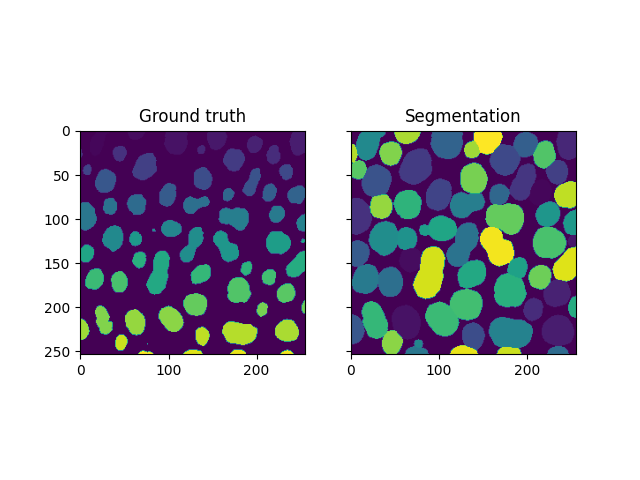

Text(0.5, 1.0, 'Segmentation')

In [52]:
# Plot side by side
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

axes[0].imshow(ground_truth)
axes[0].set_title('Ground truth')

axes[1].imshow(segmented)
axes[1].set_title('Segmentation')

## Re-match labels

Next, use the label-matching from `biapol_utilities` to assign correct labels to both images

In [53]:
segmented = biau.label.match_labels(ground_truth, segmented)

<IPython.core.display.Javascript object>


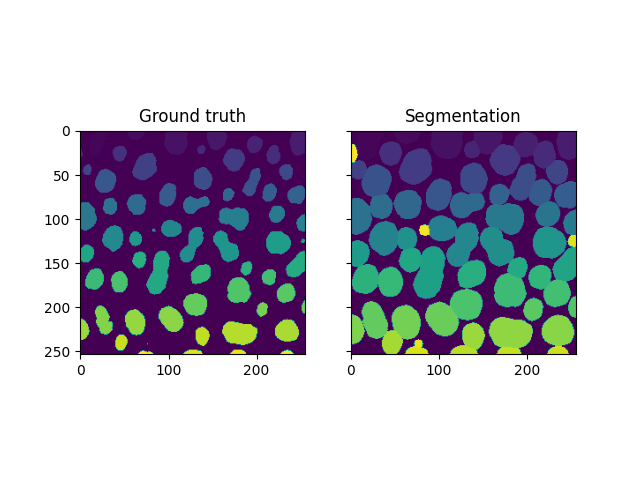

Text(0.5, 1.0, 'Segmentation')

In [54]:
# Plot side by side
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

axes[0].imshow(ground_truth)
axes[0].set_title('Ground truth')

axes[1].imshow(segmented)
axes[1].set_title('Segmentation')

## Compare labels:  Labelwise Jaccard-index

Lastly, we calculate the *label-wise Jaccard index* to measure the intersection over union (IoU) between corresponding pairs of labels.

In [55]:
result = biau.label.compare_labels(ground_truth, segmented)
result

,label,jaccard_score
0,0,0.496847
1,1,0.518102
2,2,0.470130
3,3,0.623552
4,4,0.602546
...,...,...
63,63,0.262857
64,64,0.000000
65,65,0.000000
66,66,0.000000


Let's also visualize this: To do this, we create a new image and assign the jaccard-index result value to every pixel depending on the label.

In [56]:
LUT = result['jaccard_score'].to_numpy()

LUT[0] = np.nan # set JI of background to zero
JI_map = LUT[segmented]

<IPython.core.display.Javascript object>


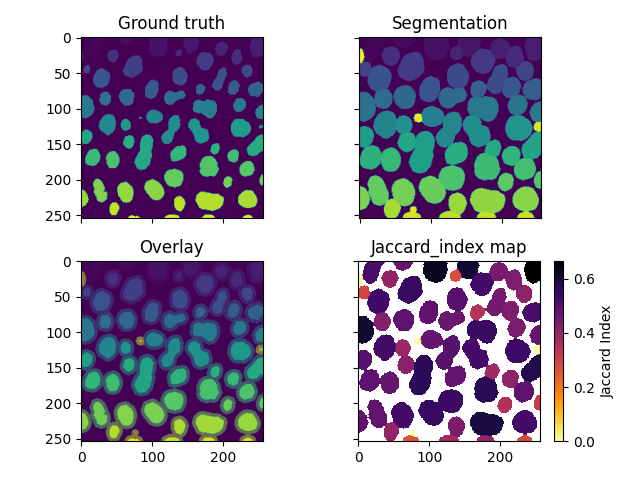

In [59]:
# Plot side by side
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

# Plot ground truth
axes[0, 0].imshow(ground_truth)
axes[0, 0].set_title('Ground truth')

# Plot segmentation
axes[0, 1].imshow(segmented)
axes[0, 1].set_title('Segmentation')

# Plot overlay
axes[1, 0].imshow(ground_truth)
axes[1, 0].imshow(segmented, alpha=0.5)
axes[1, 0].set_title('Overlay')

im = axes[1, 1].imshow(JI_map, cmap='inferno_r')
axes[1, 1].set_title('Jaccard_index map')
cbar = plt.colorbar(im)
cbar.set_label('Jaccard Index')

fig.tight_layout()



## Compare-labels: Feature-wise
It may be an interesting approach to not only check the pixel-wise agreement between segmentation and annnootation but to also check whether certain features are preserved in the segmentation. For this, the (shape-) features are calculated in both ground_truth annotation and segmented image with scikit-image regionprops.

In [79]:
properties = ['label', 'area', 'eccentricity', 'orientation']
features_gt = measure.regionprops_table(ground_truth, properties=properties)
features_seg = measure.regionprops_table(segmented, properties=properties)

features_gt = pd.DataFrame(features_gt)
features_seg = pd.DataFrame(features_seg)
print(features_seg)
print(features_gt)

    label  area  eccentricity  orientation
0       1   801      0.742751    -0.530995
1       2   385      0.831671    -1.532087
2       3  1036      0.391375    -1.529893
3       4   707      0.460863    -1.486875
4       5   700      0.738399     0.063931
..    ...   ...           ...          ...
58     63   175      0.946183     1.545368
59     64   124      0.667214    -0.067898
60     65    77      0.389750     1.048098
61     66   125      0.427143     0.373341
62     67   132      0.939831     0.007897

[63 rows x 4 columns]
    label  area  eccentricity  orientation
0       1   415      0.878888    -0.433915
1       2   181      0.822705    -1.513862
2       3   646      0.386542    -0.079653
3       4   426      0.324798    -0.400592
4       5   465      0.780472    -0.044317
..    ...   ...           ...          ...
58     59     1      0.000000     0.785398
59     60    87      0.969263    -1.560717
60     61    73      0.951468    -1.567605
61     62    49      0.942191  

Visualize as histograms

<IPython.core.display.Javascript object>


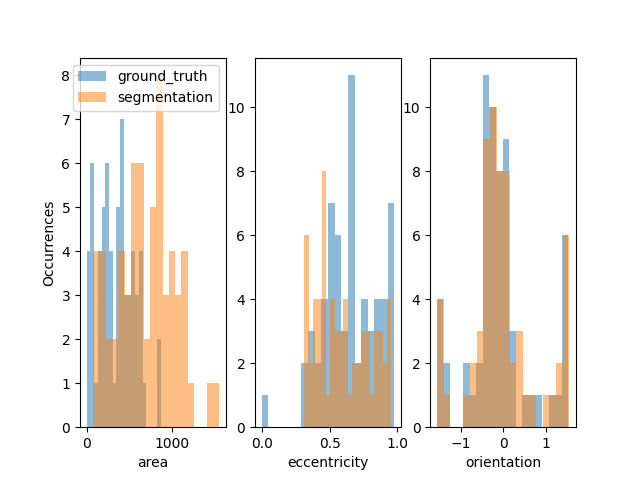

Text(0, 0.5, 'Occurrences')

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=len(properties)-1)

ax_idx = 0
for idx, prop in enumerate(properties):
    if  prop == 'label':
        continue
    
    axes[ax_idx].hist(features_gt[prop], label='ground_truth', bins=20, alpha=0.5)
    axes[ax_idx].hist(features_seg[prop], label='segmentation', bins=20, alpha=0.5)
    axes[ax_idx].set_xlabel(prop)
    ax_idx += 1
    
axes[0].legend()
axes[0].set_ylabel('Occurrences')